In [156]:
import neural_process
import numpy as np
import joblib
import torch
import json
import numpy as np
import os
import sys
import torch
from time import strftime
import matplotlib.pyplot as plt
import utils

In [157]:
aluminium_inputs = joblib.load('../Vectors/single_f_aluminium_vectors')
aluminium_labels = joblib.load('../Vectors/single_f_aluminium_labels')
aluminium_dates = joblib.load('../Vectors/single_f_aluminium_dates')

In [158]:
train_d = torch.from_numpy(aluminium_inputs)
train_l = torch.from_numpy(aluminium_labels)

In [159]:
train_d = torch.squeeze(train_d, dim = 1)

In [160]:
train_data = train_d[0:600]
train_labels = train_l[0:600]
test_data = train_d[600:]
test_labels = train_l[600:]

In [161]:
test_data.shape

torch.Size([240, 55])

In [162]:
train_data = torch.reshape(train_data, (2,300,55))
train_labels = torch.reshape(train_labels, (2,300,1))

test_data = torch.reshape(test_data, (2,120,55))
test_labels = torch.reshape(test_labels, (2,120,1))

In [163]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [164]:
# Create a folder to store experiment results
timestamp = strftime("%Y-%m-%d_%H-%M")
directory = "results_{}".format(timestamp)
if not os.path.exists(directory):
    os.makedirs(directory)

In [165]:
# Open config file
config_path = 'config.json'
with open(config_path) as config_file:
    config = json.load(config_file)

In [166]:
batch_size = config["batch_size"]
r_dim = config["r_dim"]
h_dim = config["h_dim"]
z_dim = config["z_dim"]
num_context_range = config["num_context_range"]
num_extra_target_range = config["num_extra_target_range"]
epochs = config["epochs"]

In [167]:
np_model = neural_process.NeuralProcess(train_data.shape[2], train_labels.shape[2], r_dim, z_dim, h_dim).to(device)

In [168]:
optimizer = torch.optim.Adam(np_model.parameters(), lr=config["lr"])

In [169]:
np_trainer = neural_process.NeuralProcessTrainer(device, np_model, optimizer, num_context_range, num_extra_target_range, print_freq=100)

In [170]:
dataset= torch.utils.data.TensorDataset(train_data, train_labels)
data_loader= torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

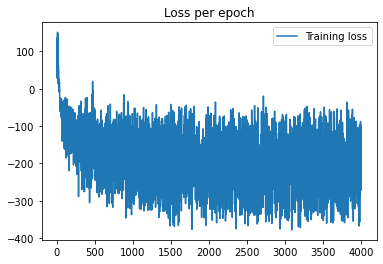

In [277]:
loss_list = np_trainer.train(data_loader, epochs)
plt.plot(np.arange(len(loss_list)),loss_list,label='Training loss')
plt.legend()
plt.title("Loss per epoch")
plt.show()

In [278]:
x_context, y_context, x_target, y_target = neural_process.context_target_split(test_data, test_labels, 80, 40)

In [279]:
x_context.shape

torch.Size([2, 80, 55])

In [280]:
preds = np_model(x_context.float(), y_context.float(), x_target.float(), None)

In [281]:
mean_pred = torch.reshape(preds.loc,(preds.loc.shape[0]*preds.loc.shape[1],preds.loc.shape[2])).detach().numpy()
pred_var = torch.reshape(preds.scale,(preds.scale.shape[0]*preds.scale.shape[1],preds.scale.shape[2])).detach().numpy()**2
y_target = np.reshape(y_target,(y_target.shape[0]*y_target.shape[1],y_target.shape[2]))

In [282]:
var = []
for v in pred_var:
    var.append(v[0])

In [283]:
lower_val, upper_val = utils.calculate_conf_interval(mean_pred,var,interval_rate = 0.80)
l = []
u = []
for i,lv in enumerate(lower_val):
    l.append(lv[0])
    u.append(upper_val[i][0])

In [284]:
mean_pred = mean_pred[0:100]
y_target = y_target[0:100]
l = l[0:100]
u = u[0:100]

In [285]:
mean = []
for m in mean_pred:
    mean.append(m[0])

In [286]:
print(len(u))

100


In [292]:
print(u[0])
print(l[0])
print(mean[0])


0.02511336
-0.23131071
-0.103098676


In [287]:
print(len(l))

100


In [288]:
print(len(mean))

100


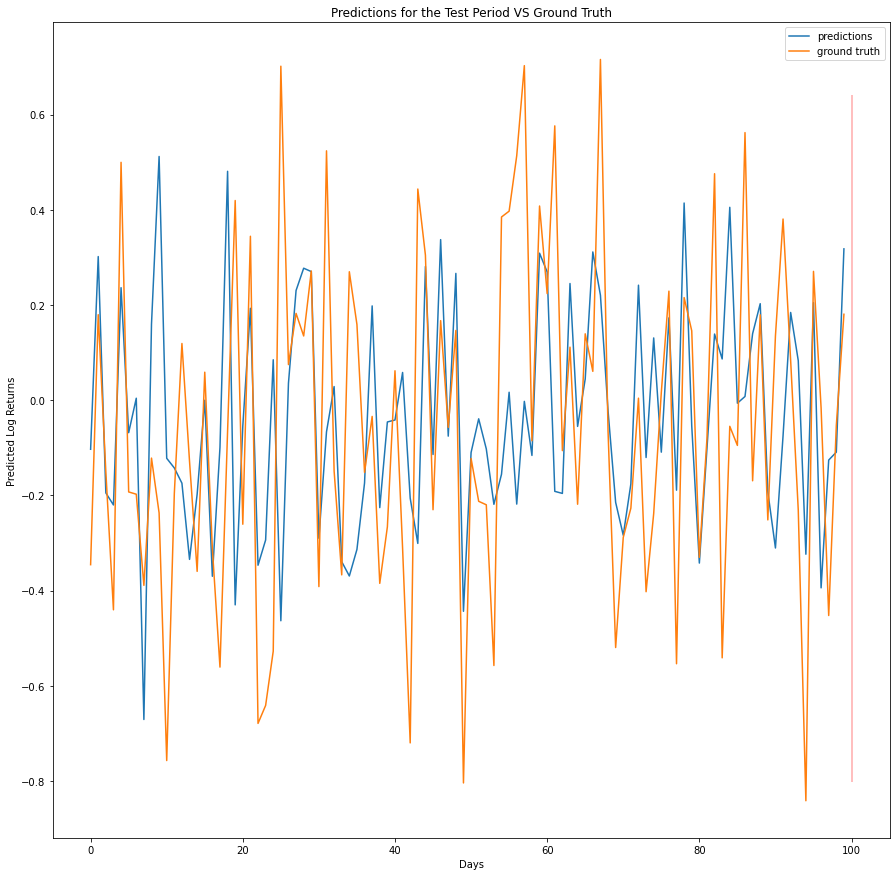

In [293]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(np.arange(len(mean)),mean,label = 'predictions')
plt.plot(np.arange(len(mean)), y_target, label = "ground truth")
ax.fill_between(len(mean), 10*l, 10*u, color='r', alpha=.25)
plt.xlabel('Days')
plt.ylabel('Predicted Log Returns')
plt.title('Predictions for the Test Period VS Ground Truth')
plt.legend()
plt.show()

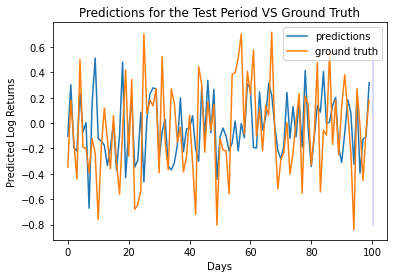

In [296]:
fig, ax = plt.subplots()
ax.fill_between(len(mean), 10*l, 10*u, color='b', alpha=.15)
ax.plot(np.arange(len(mean)),mean,label = 'predictions')
plt.plot(np.arange(len(mean)), y_target, label = "ground truth")
plt.xlabel('Days')
plt.ylabel('Predicted Log Returns')
plt.title('Predictions for the Test Period VS Ground Truth')
plt.legend()
plt.show()